<a href="https://colab.research.google.com/github/Saumik37/CVPR/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Network

In [28]:
import random
import PIL
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [29]:
import numpy as np
from typing import Union, Tuple, Optional

def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, n_classes: Optional[int] = None) -> np.ndarray:
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    if n_classes is None:
        n_classes = max(np.max(y_true), np.max(y_pred)) + 1

    result = np.histogram2d(y_true, y_pred, bins=n_classes, range=[[0, n_classes], [0, n_classes]])[0]
    return result.astype(int)

def precision_score(y_true: np.ndarray, y_pred: np.ndarray, average: str = 'macro') -> Union[float, np.ndarray]:
    cm = confusion_matrix(y_true, y_pred)

    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp

    numerator = tp
    denominator = tp + fp
    precisions = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator != 0)

    if average == 'macro':
        return np.mean(precisions)
    return precisions

def recall_score(y_true: np.ndarray, y_pred: np.ndarray, average: str = 'macro') -> Union[float, np.ndarray]:
    cm = confusion_matrix(y_true, y_pred)

    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp

    numerator = tp
    denominator = tp + fn
    recalls = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator != 0)

    if average == 'macro':
        return np.mean(recalls)
    return recalls

def f1_score(y_true: np.ndarray, y_pred: np.ndarray, average: str = 'macro') -> Union[float, np.ndarray]:
    p = precision_score(y_true, y_pred, average=None)
    r = recall_score(y_true, y_pred, average=None)

    numerator = 2 * p * r
    denominator = p + r

    f1s = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator != 0)

    if average == 'macro':
        return np.mean(f1s)
    return f1s

def label_binarize(y: np.ndarray, classes: np.ndarray) -> np.ndarray:
    return (np.array(y)[:, None] == np.array(classes)[None, :]).astype(int)

def auc(x: np.ndarray, y: np.ndarray) -> float:
    return np.trapz(y, x)

def roc_curve(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    desc_score_indices = np.argsort(y_score)[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    tps = np.cumsum(y_true)[threshold_idxs]
    fps = (1 + threshold_idxs) - tps

    tpr = np.zeros_like(tps, dtype=float)
    fpr = np.zeros_like(fps, dtype=float)

    if tps[-1] > 0:
        tpr = tps / tps[-1]
    if fps[-1] > 0:
        fpr = fps / fps[-1]

    return np.r_[0, fpr], np.r_[0, tpr], np.r_[y_score[0]+1, y_score[threshold_idxs]]

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Any

def plot_confusion_matrix(cm: np.ndarray, classes: List[str], title: str = 'Confusion Matrix', cmap: Any = plt.cm.Blues) -> None:
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]:.0f}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Code Modifications & Challenges

In [31]:
import numpy as np
from typing import List, Dict, Tuple, Union

class NeuralNetwork:
    def __init__(self, input_size: int, hidden_sizes: List[int], output_size: int, learning_rate: float = 0.01):
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.learning_rate = learning_rate
        self.params = self._initialize_parameters()
        self.cache = {}

    def _initialize_parameters(self) -> Dict[str, np.ndarray]:
        params = {}
        for l in range(1, len(self.layer_sizes)):
            input_dim = self.layer_sizes[l-1]
            output_dim = self.layer_sizes[l]

            params[f'W{l}'] = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
            params[f'b{l}'] = np.zeros((1, output_dim))
        return params

    def relu(self, Z: np.ndarray) -> np.ndarray:
        return np.maximum(0, Z)

    def relu_derivative(self, Z: np.ndarray) -> np.ndarray:
        return (Z > 0).astype(float)

    def softmax(self, Z: np.ndarray) -> np.ndarray:
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.cache['A0'] = X
        L = len(self.layer_sizes) - 1

        for l in range(1, L):
            Z = np.dot(self.cache[f'A{l-1}'], self.params[f'W{l}']) + self.params[f'b{l}']
            self.cache[f'Z{l}'] = Z
            self.cache[f'A{l}'] = self.relu(Z)

        Z_last = np.dot(self.cache[f'A{L-1}'], self.params[f'W{L}']) + self.params[f'b{L}']
        self.cache[f'Z{L}'] = Z_last
        self.cache[f'A{L}'] = self.softmax(Z_last)

        return self.cache[f'A{L}']

    def backward(self, X: np.ndarray, y: np.ndarray) -> None:
        m = X.shape[0]
        L = len(self.layer_sizes) - 1

        y_one_hot = np.zeros((m, self.layer_sizes[-1]))
        y_one_hot[np.arange(m), y] = 1

        dZ = self.cache[f'A{L}'] - y_one_hot

        for l in range(L, 0, -1):
            A_prev = self.cache[f'A{l-1}']
            W = self.params[f'W{l}']

            dW = (1/m) * np.dot(A_prev.T, dZ)
            db = (1/m) * np.sum(dZ, axis=0, keepdims=True)

            if l > 1:
                dA_prev = np.dot(dZ, W.T)
                dZ = dA_prev * self.relu_derivative(self.cache[f'Z{l-1}'])

            self.params[f'W{l}'] -= self.learning_rate * dW
            self.params[f'b{l}'] -= self.learning_rate * db

    def compute_loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        log_likelihood = -np.log(y_pred[np.arange(m), y_true])
        return np.sum(log_likelihood) / m

    def train(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000, print_every: int = 200) -> List[float]:
        loss_history = []
        for i in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            self.backward(X, y)
            loss_history.append(loss)

            if i % print_every == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")
        return loss_history

    def predict(self, X: np.ndarray) -> np.ndarray:
        y_pred_probs = self.forward(X)
        return np.argmax(y_pred_probs, axis=1)

Dataset Generation

In [32]:
import numpy as np
from typing import Tuple

def generate_data(n_samples: int = 1500, test_size: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    n_per_class = n_samples // 5
    X_list = []
    y_list = []

    X_center = np.random.uniform(0.4, 0.6, (n_per_class, 2))
    X_list.append(X_center)
    y_list.append(np.full(n_per_class, 4))

    quadrants = [
        (0.0, 0.5, 0.5, 1.0, 0),
        (0.5, 1.0, 0.5, 1.0, 1),
        (0.0, 0.5, 0.0, 0.5, 2),
        (0.5, 1.0, 0.0, 0.5, 3)
    ]

    for x_min, x_max, y_min, y_max, label in quadrants:
        candidates = np.random.uniform(
            [x_min, y_min],
            [x_max, y_max],
            (int(n_per_class * 1.5), 2)
        )

        in_center = (
            (candidates[:, 0] >= 0.4) & (candidates[:, 0] <= 0.6) &
            (candidates[:, 1] >= 0.4) & (candidates[:, 1] <= 0.6)
        )

        valid_samples = candidates[~in_center][:n_per_class]

        X_list.append(valid_samples)
        y_list.append(np.full(len(valid_samples), label))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    split_idx = int(len(X) * (1 - test_size))
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

X_train, X_test, y_train, y_test = generate_data(1500)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1200, 2), Test shape: (300, 2)


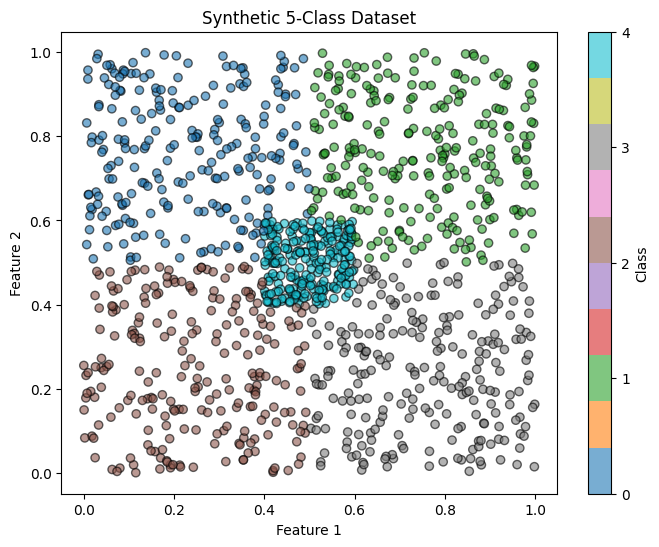

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dataset(X: np.ndarray, y: np.ndarray, title: str = "Synthetic 5-Class Dataset", cmap: str = 'tab10') -> None:
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.6, edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label='Class', ticks=range(5))
    plt.show()

plot_dataset(X_train, y_train)

Neural Network Architecture:


1.   Input Layer: 2 neurons (for 2 features)
2.   Hidden Layer 1: 64 neurons, ReLU activation
1.   Hidden Layer 2: 32 neurons, ReLU activation
2.   Hidden Layer 3: 16 neurons, ReLU activation
1.   Output Layer: 5 neurons, Softmax activation



Training:





Epoch 0, Loss: 1.6983
Epoch 200, Loss: 0.1994
Epoch 400, Loss: 0.2090
Epoch 600, Loss: 0.0943
Epoch 800, Loss: 0.0778
Epoch 1000, Loss: 0.0754
Epoch 1200, Loss: 0.0689
Epoch 1400, Loss: 0.0742
Epoch 1600, Loss: 0.0729
Epoch 1800, Loss: 0.0682
Epoch 2000, Loss: 0.0698
Epoch 2200, Loss: 0.0710
Epoch 2400, Loss: 0.0681
Epoch 2600, Loss: 0.0664
Epoch 2800, Loss: 0.0625


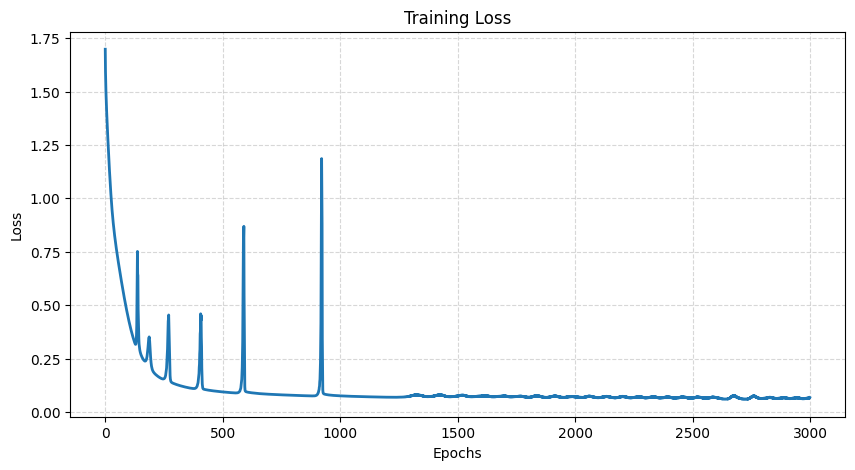

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def train_and_plot(X: np.ndarray, y: np.ndarray) -> NeuralNetwork:
    input_size = 2
    hidden_sizes = [64, 32, 16]
    output_size = 5
    learning_rate = 0.1
    epochs = 3000

    nn = NeuralNetwork(input_size, hidden_sizes, output_size, learning_rate)
    loss_history = nn.train(X, y, epochs)

    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, linewidth=2)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return nn

trained_model = train_and_plot(X_train, y_train)

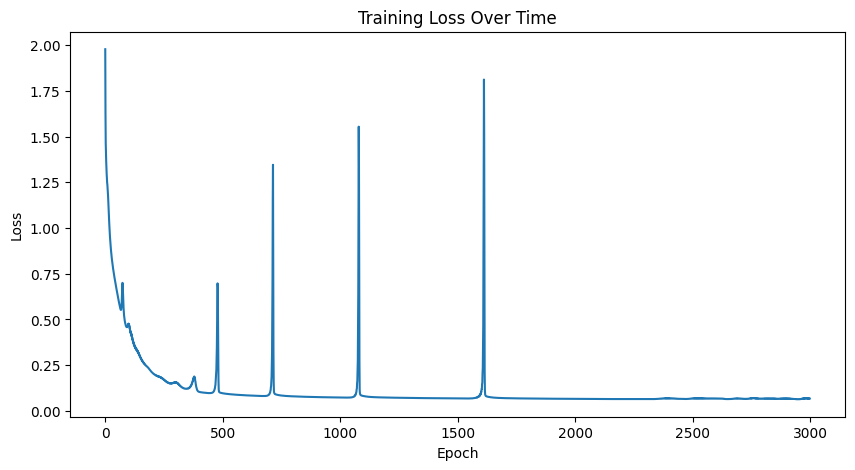

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List

def plot_loss(loss_history: List[float]) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title("Training Loss Over Time")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

plot_loss(loss_history)


Evaluation:

In [36]:
def evaluate_model(nn: NeuralNetwork, X_test: np.ndarray, y_test: np.ndarray) -> None:
    y_pred_probs = nn.forward(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test, y_pred)
    prec_macro = precision_score(y_test, y_pred, average='macro')
    rec_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"Overall Accuracy:  {acc:.4f}")
    print(f"Macro Precision: {prec_macro:.4f}")
    print(f"Macro Recall:    {rec_macro:.4f}")
    print(f"Macro F1 Score:  {f1_macro:.4f}")
    print("\n--- Per-Class Metrics ---")

    prec_per_class = precision_score(y_test, y_pred, average=None)
    rec_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)

    for i in range(len(prec_per_class)):
        print(f"Class {i}: Precision={prec_per_class[i]:.4f}, Recall={rec_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")

evaluate_model(nn, X_test, y_test)

Overall Accuracy:  0.9633
Macro Precision: 0.9644
Macro Recall:    0.9629
Macro F1 Score:  0.9633

--- Per-Class Metrics ---
Class 0: Precision=0.9420, Recall=0.9701, F1=0.9559
Class 1: Precision=0.9792, Recall=0.9792, F1=0.9792
Class 2: Precision=1.0000, Recall=0.9531, F1=0.9760
Class 3: Precision=0.9552, Recall=1.0000, F1=0.9771
Class 4: Precision=0.9455, Recall=0.9123, F1=0.9286


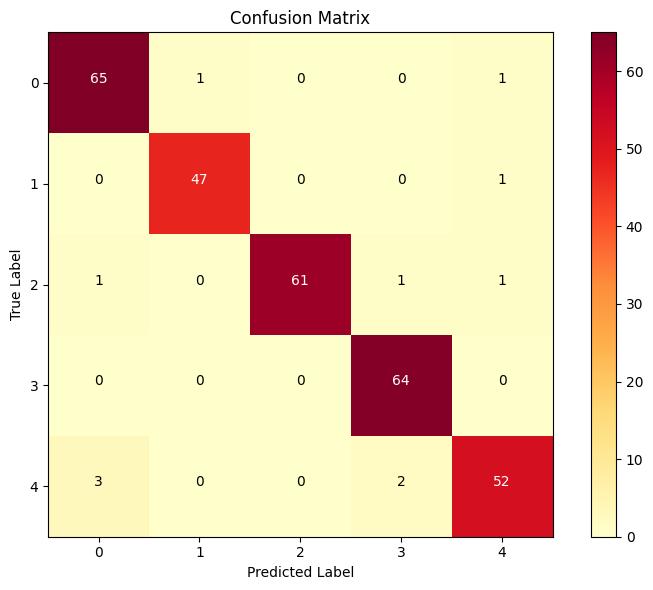

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List

def plot_confusion_heatmap(y_true: np.ndarray, y_pred: np.ndarray, classes: List[int]) -> None:
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrRd)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{int(cm[i, j])}",
                     horizontalalignment="center",
                     color="black" if cm[i, j] < thresh else "white")

    plt.tight_layout()
    plt.show()

y_pred_probs = nn.forward(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

classes = [0, 1, 2, 3, 4]
plot_confusion_heatmap(y_test, y_pred, classes)

ROC Curves

/tmp/ipython-input-2617855791.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)


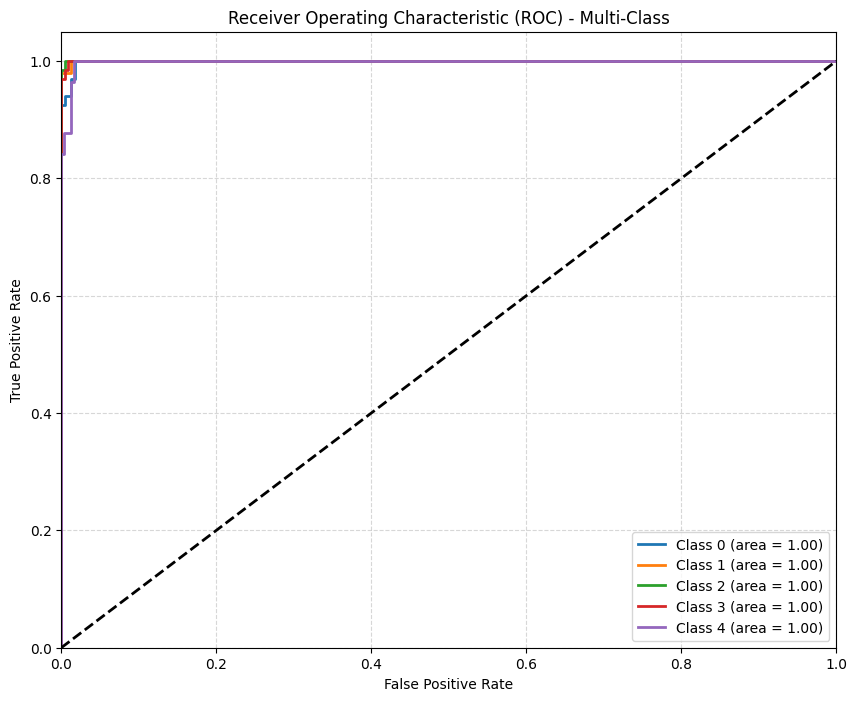

In [38]:
def plot_multiclass_roc(y_test: np.ndarray, y_pred_probs: np.ndarray, classes: List[int]) -> None:
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

classes = [0, 1, 2, 3, 4]
plot_multiclass_roc(y_test, y_pred_probs, classes)

Hyperparameter Comparison:

--- Hyperparameter Tuning ---
Training with LR=0.01...
Epoch 0, Loss: 1.9784
Epoch 200, Loss: 0.9131
Epoch 400, Loss: 0.7217
Epoch 600, Loss: 0.5662
Epoch 800, Loss: 0.4292
-> LR=0.01, Accuracy=0.9267
Training with LR=0.1...
Epoch 0, Loss: 1.7716
Epoch 200, Loss: 0.3111
Epoch 400, Loss: 0.1633
Epoch 600, Loss: 0.1114
Epoch 800, Loss: 0.0957
-> LR=0.1, Accuracy=0.9700
Training with LR=0.5...
Epoch 0, Loss: 1.8162
Epoch 200, Loss: 0.2499
Epoch 400, Loss: 0.1402
Epoch 600, Loss: 0.1920
Epoch 800, Loss: 0.0926
-> LR=0.5, Accuracy=0.9433


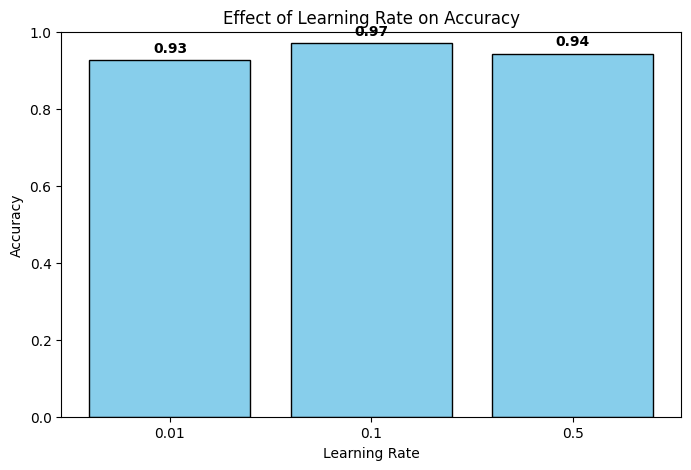

In [39]:
def compare_learning_rates(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, lrs: List[float]) -> List[Tuple[float, float]]:
    results = []
    accuracies = []

    print("--- Hyperparameter Tuning ---")
    for lr in lrs:
        print(f"Training with LR={lr}...")

        temp_nn = NeuralNetwork(input_size=2, hidden_sizes=[64, 32, 16], output_size=5, learning_rate=lr)
        temp_nn.train(X_train, y_train, epochs=1000)

        probs = temp_nn.forward(X_test)
        preds = np.argmax(probs, axis=1)
        acc = accuracy_score(y_test, preds)

        results.append((lr, acc))
        accuracies.append(acc)
        print(f"-> LR={lr}, Accuracy={acc:.4f}")

    plt.figure(figsize=(8, 5))
    plt.bar([str(lr) for lr in lrs], accuracies, color='skyblue', edgecolor='black')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.title('Effect of Learning Rate on Accuracy')
    plt.ylim(0, 1.0)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.show()

    return results

lrs = [0.01, 0.1, 0.5]
results = compare_learning_rates(X_train, y_train, X_test, y_test, lrs)


--- Starting Experiment 2: Smaller Model ---
Epoch 0, Loss: 1.5783
Epoch 200, Loss: 0.5092
Epoch 400, Loss: 0.1922
Epoch 600, Loss: 0.1322
Epoch 800, Loss: 0.1086
Epoch 1000, Loss: 0.0965
Epoch 1200, Loss: 0.0889
Epoch 1400, Loss: 0.0838
Epoch 1600, Loss: 0.0801
Epoch 1800, Loss: 0.0772
Model V2 Accuracy: 0.9700

--- Performance Comparison ---
Model V1 (64-32-16, lr=0.10): Accuracy = 0.9633
Model V2 (16-8-8,   lr=0.05): Accuracy = 0.9700


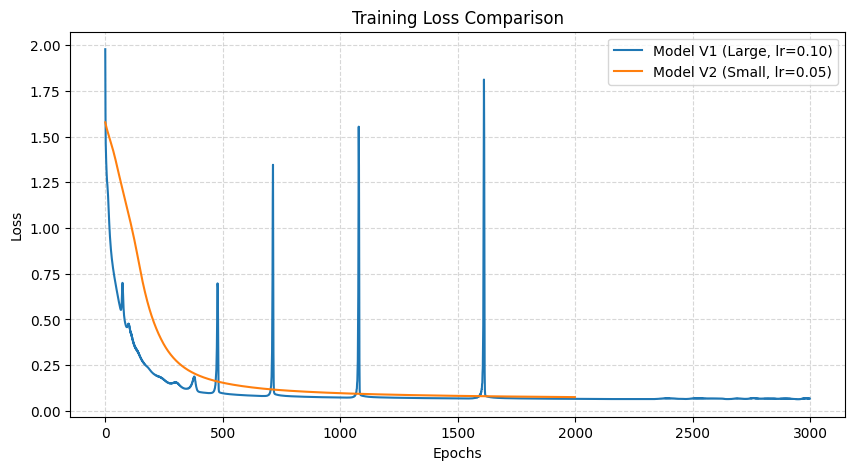

In [40]:
print("\n--- Starting Experiment 2: Smaller Model ---")

nn_v2 = NeuralNetwork(input_size=2, hidden_sizes=[16, 8, 8], output_size=5, learning_rate=0.05)
loss_history_v2 = nn_v2.train(X_train, y_train, epochs=2000)

y_pred_v2 = nn_v2.predict(X_test)
acc_v2 = accuracy_score(y_test, y_pred_v2)
print(f"Model V2 Accuracy: {acc_v2:.4f}")

y_pred_v1 = nn.predict(X_test)
acc_v1 = accuracy_score(y_test, y_pred_v1)

print("\n--- Performance Comparison ---")
print(f"Model V1 (64-32-16, lr=0.10): Accuracy = {acc_v1:.4f}")
print(f"Model V2 (16-8-8,   lr=0.05): Accuracy = {acc_v2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Model V1 (Large, lr=0.10)')
plt.plot(loss_history_v2, label='Model V2 (Small, lr=0.05)')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()